## Mental Health Challenge - Kaggle playground series - binary classification

Partly inspired by [this notebook](https://www.kaggle.com/code/annastasy/mental-health-eda-ensemble/notebook).

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import optuna

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

# Color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

### Setup
We load the data into a dataframe and take a first look at it.

In [3]:
df_train = pd.read_csv("train.csv", index_col="id")
df_test  = pd.read_csv("test.csv", index_col="id")
df_train.head(5)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
df_train.describe().round(2)

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.00,27897.00,112782.00,27898.00,27897.00,112790.00,140700.00,140696.00,140700.00
mean,40.39,3.14,3.00,7.66,2.94,2.97,6.25,2.99,0.18
std,12.38,1.38,1.41,1.46,1.36,1.42,3.85,1.41,0.39
min,18.00,1.00,1.00,5.03,1.00,1.00,0.00,1.00,0.00
25%,29.00,2.00,2.00,6.29,2.00,2.00,3.00,2.00,0.00
50%,42.00,3.00,3.00,7.77,3.00,3.00,6.00,3.00,0.00
75%,51.00,4.00,4.00,8.92,4.00,4.00,10.00,4.00,0.00
max,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00


### Understanding the data
#### Missing values
Some analysis on missing values in this section. Let us look first for how many missing values are in each column.

In [5]:
missing_val = df_train.isnull().sum()
missing_val

Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

Here is a useful way to visualize missing values using seaborn:

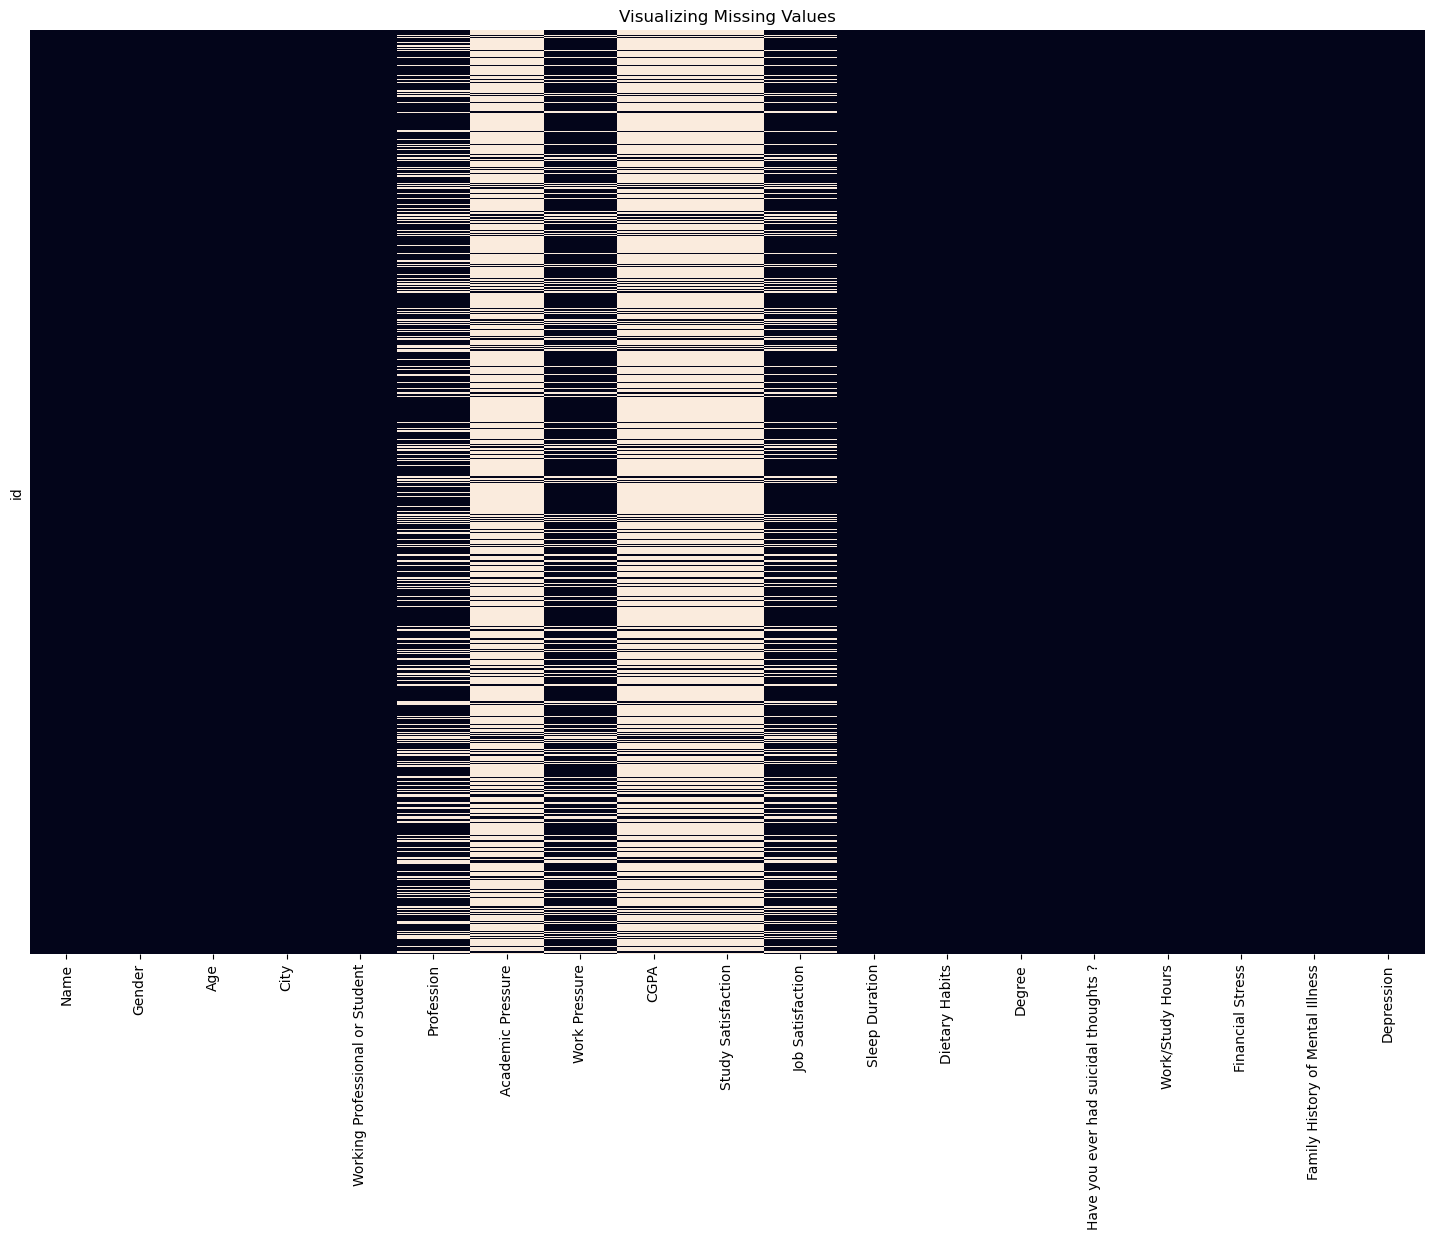

In [6]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False);

The above suggests that almost all missing values result from the fact that the "Study Satisfaction" and "Job Satisfaction" columns can only have valid values for Students and Professionals, respectively. The same applies to "Work Pressure" and "Academic Pressure". Merging these columns will probably eliminate most of the missing values.

#### Categorical and numerical features

Next up, we look at the different types of features.

In [7]:
# Select categorical and numerical features
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop("Depression")

# Print out column information
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())


Categorical Columns: ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical Columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


How many unique values do we have for each categorical column?

In [8]:
for col in categorical_columns:
    num_unique = df_train[col].nunique()
    print(f"'{col}' has {num_unique} unique categories.")

'Name' has 422 unique categories.
'Gender' has 2 unique categories.
'City' has 98 unique categories.
'Working Professional or Student' has 2 unique categories.
'Profession' has 64 unique categories.
'Sleep Duration' has 36 unique categories.
'Dietary Habits' has 23 unique categories.
'Degree' has 115 unique categories.
'Have you ever had suicidal thoughts ?' has 2 unique categories.
'Family History of Mental Illness' has 2 unique categories.


Let us look at the top and bottom 10 unique value counts for each non-binary categorical feature:

In [9]:
categorical_nb = [col for col in categorical_columns if df_train[col].nunique() > 2]

for col in categorical_nb:
    print(f"\n Top value counts in '{col}':\n{df_train[col].value_counts().head(10)}")
    print(f"\n Bottom value counts in '{col}':\n{df_train[col].value_counts().tail(10)}")


 Top value counts in 'Name':
Name
Rohan          3178
Aarav          2336
Rupak          2176
Aaradhya       2045
Anvi           2035
Raghavendra    1877
Vani           1657
Tushar         1596
Ritvik         1589
Shiv           1568
Name: count, dtype: int64

 Bottom value counts in 'Name':
Name
Aariket    1
Aarat      1
Vohi       1
Vavya      1
Ishaam     1
Anhil      1
Rieta      1
Zahra      1
Jathesh    1
Aarun      1
Name: count, dtype: int64

 Top value counts in 'City':
City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Name: count, dtype: int64

 Bottom value counts in 'City':
City
Gurgaon    1
Tolkata    1
Anvi       1
Krinda     1
Ayansh     1
Shrey      1
Ivaan      1
Vaanya     1
Gaurav     1
Unirar     1
Name: count, dtype: int64

 Top value counts in 'Profession':
Profession
Teacher             249

How many unique categories occur less than 10 times, i.e. non very meaningful entries when it comes to prediction?

In [10]:
for col in categorical_nb:
    num_values = df_train[col].value_counts()
    print(f"\n {num_values[num_values < 10].shape[0]} values occuring less than 10 times in '{col}':\n{num_values[num_values < 10]}")


 205 values occuring less than 10 times in 'Name':
Name
Aarash     3
Rupar      3
Kolkata    3
Tarsh      3
Shivvi     2
          ..
Anhil      1
Rieta      1
Zahra      1
Jathesh    1
Aarun      1
Name: count, Length: 205, dtype: int64

 68 values occuring less than 10 times in 'City':
City
Mihir      7
Nandini    4
Mahi       3
Vidya      3
City       3
          ..
Shrey      1
Ivaan      1
Vaanya     1
Gaurav     1
Unirar     1
Name: count, Length: 68, dtype: int64

 29 values occuring less than 10 times in 'Profession':
Profession
Student                 7
Academic                5
Profession              3
Yogesh                  3
BCA                     3
Unemployed              3
LLM                     2
PhD                     2
MBA                     2
Dev                     1
BE                      1
Family Consultant       1
Visakhapatnam           1
Pranav                  1
Analyst                 1
M.Ed                    1
Moderate                1
Nagpur        

### Data preprocessing and feature engineering
Based on the above, we will prepare our data for the training process. We will also directly prepare the test data for prediction.

#### Merging Satisfaction and Pressure features

In [11]:
for df in [df_train, df_test]:
    df["Satisfaction"] = df["Study Satisfaction"].combine_first(df["Job Satisfaction"])
    df["Pressure"] = df["Academic Pressure"].combine_first(df["Work Pressure"])
    df.drop(["Study Satisfaction", "Job Satisfaction", "Academic Pressure", "Work Pressure"], axis=1, inplace=True)

#### Binary categorical features
For the four categorical features that are binary (i.e. only have two unique values), we just use $0$-$1$-encoding.

In [12]:
for df in [df_train, df_test]:
    df["Working Professional or Student"] = df["Working Professional or Student"].map({"Student": 1, "Working Professional": 0})
    df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
    df["Have you ever had suicidal thoughts ?"] = df["Have you ever had suicidal thoughts ?"].map({"Yes": 1, "No": 0})
    df["Family History of Mental Illness"] = df["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

#### Small cardinality categorical features

For the features "Dietary Habits" and "Sleep Duration", we saw above that there are essentially only three and four relevant categories. Furthermore, the features carry some natural order (unhealthy << healthy, no sleep << much sleep). We therefore encode them with integer values respecting this order and all the remaining values (many of which are gibberish) are mapped to NaN. 

In [13]:
for df in [df_train, df_test]:
    df["Dietary Habits"] = df["Dietary Habits"].map({"Unhealthy": 0, "Moderate": 1, "Healthy": 2})
    df["Sleep Duration"] = df["Sleep Duration"].map({"Less than 5 hours": 0, "5-6 hours": 1, "7-8 hours": 2, "More than 8 hours": 3})

#### Encoding the remaining categorical features
There are many possible ways to do this, the most common being ordinal encoding, one-hot encoding and target encoding. The latter requires more care regarding data-leakage in the training process, but is probably more appropriate choice here because there is no natural order in the remaining features. For simplicity, we go with the ordinal encoding approach.

In [14]:
# Specifty remaining categorical columns

categorical_columns = ['Profession', 'Name', 'City', 'Degree']

for col in categorical_columns:
    enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, encoded_missing_value=-1, dtype=np.int32)
    df_train[col] = enc.fit_transform(pd.DataFrame(df_train[col]))
    df_test[col] = enc.transform(pd.DataFrame(df_test[col]))

Taking a look again at the missing values:

In [15]:
print(df_train.isnull().sum(), "\n\n", df_test.isnull().sum())

Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                    0
CGPA                                     112802
Sleep Duration                               79
Dietary Habits                               27
Degree                                        0
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
Satisfaction                                 15
Pressure                                     21
dtype: int64 

 Name                                         0
Gender                                       0
Age                                          0
City                       

CGPA is missing for all non-students, the remaining number of NaN-values is insignificant. We could either just ignore the remaining missing values, since Tree-based models like XGBoost can handle them well. Another option for example is to set CGPA to $-1$ for non-students and for all other columns to replace the NaN-values by their median.

In [16]:
df_train.fillna({"CGPA": -1}, inplace=True)
df_test.fillna({"CGPA": -1}, inplace=True)

nan_cols = ["Sleep Duration", "Dietary Habits", "Financial Stress", "Satisfaction", "Pressure"]

for col in nan_cols:
    med = df_train[col].median()
    df_train.fillna({col:med}, inplace=True)
    df_test.fillna({col:med}, inplace=True)


#### Remaining missing values

In [18]:
print(df_train.isnull().sum(), "\n\n", df_test.isnull().sum())

Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
CGPA                                     0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
Satisfaction                             0
Pressure                                 0
Age_Pressure                             0
dtype: int64 

 Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student       

#### Mutual information

                                       Mutual Information
Feature                                                  
Age                                              0.199868
Profession                                       0.138222
Age_Pressure                                     0.131383
CGPA                                             0.118567
Working Professional or Student                  0.113169
Have you ever had suicidal thoughts ?            0.078950
Pressure                                         0.041208
Degree                                           0.040993
Financial Stress                                 0.031202
Work/Study Hours                                 0.022715
Dietary Habits                                   0.020862
Gender                                           0.017505
Family History of Mental Illness                 0.016828
Satisfaction                                     0.016047
Name                                             0.014737
Sleep Duration

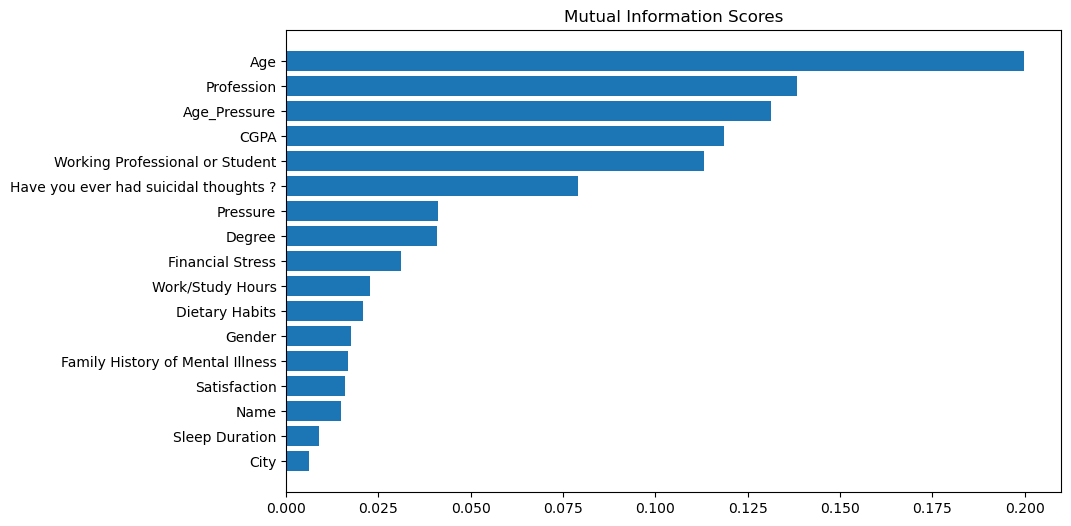

In [19]:
X = df_train.drop(columns=["Depression"])
y = df_train["Depression"]

mi_scores = mutual_info_classif(X, y)

# Wrap in a DataFrame for better interpretation
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores}).sort_values(by='Mutual Information', ascending=False)
mi_df.set_index("Feature", inplace=True)
print(mi_df)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(10, 6))
plot_mi_scores(pd.Series(mi_df["Mutual Information"]))

#### Correlation matrix

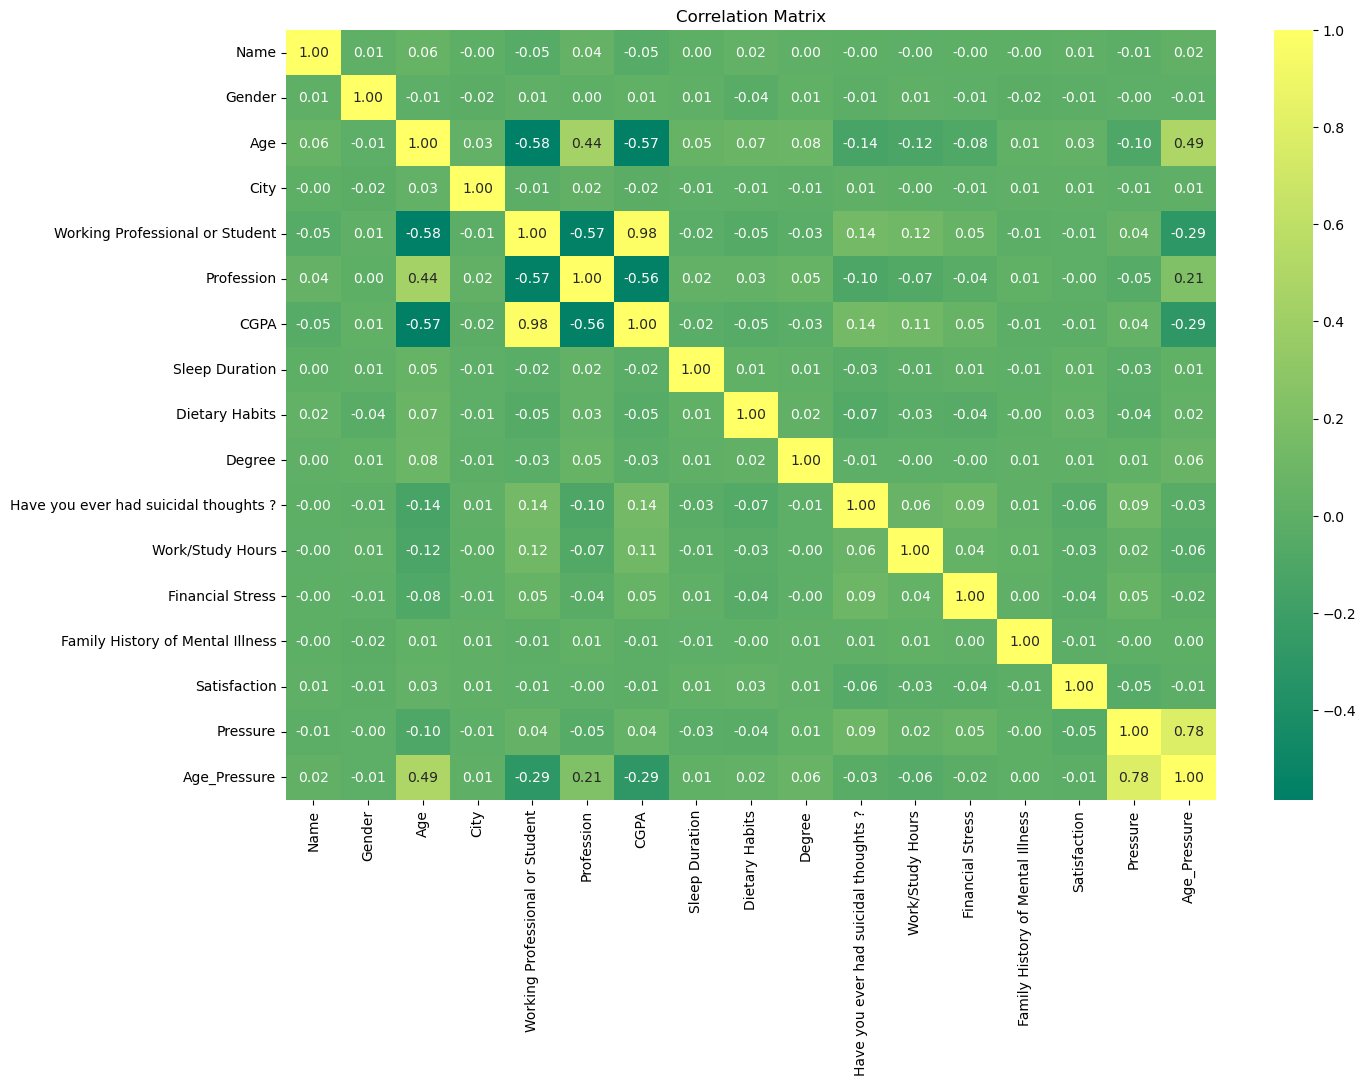

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(), annot=True, cmap='summer', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Interaction feature between Age and Pressure
This was suggested in [this notebook](https://www.kaggle.com/code/annastasy/mental-health-eda-ensemble/notebook).

In [21]:
df_train['Age_Pressure'] = df_train["Age"] * df_train["Pressure"]
df_test['Age_Pressure'] = df_test["Age"] * df_test["Pressure"]

## Training the Model
We will train a few models and present different procedures to find a good set of hyperparameters. We will use the libraries XGBoost and LightGBM.

In [22]:
X_train = df_train.drop(columns=["Depression"])
X_test = df_test
y_train = df_train["Depression"]

### Determining a good set of hyperparameters using GridSearchCV
#### XGBoost

In [23]:
# Define a set of hyperparameter combinations

param_grid = {
    'n_estimators': [400, 450, 500],                # Number of trees
    'max_depth': [3, 4, 5],                        # Maximum tree depth
    'learning_rate': [0.05, 0.1, 0.2],            # Step size shrinkage
    'min_child_weight': [3],                 # Minimum sum of weights in a child
    'subsample': [0.8],                       # Row sampling ratio
    'colsample_bytree': [0.82],                # Feature sampling ratio per tree                      
    'alpha': [45],
    'gamma': [1]
}

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,  # 4-fold cross-validation
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best parameters found: {'alpha': 45, 'colsample_bytree': 0.82, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 450, 'subsample': 0.8}
Best accuracy score: 0.9390120824449183


#### LightGBM

In [24]:
# Define a set of hyperparameter combinations
param_grid = {
    'num_leaves': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],  # -1 indicates no limit
    'min_child_samples': [5, 10],
    'subsample': [0.8, 0.9],  # Fraction of data used for training
}

# Initialize LightGBM classifier
gbm_clf = lgb.LGBMClassifier(metric='binary_logloss', objective='binary', verbose=-1)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=gbm_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 4-fold cross-validation
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 100, 'subsample': 0.8}
Best accuracy score: 0.939275053304904


### Determining a good set of hyperparameters using RandomizedSearchCV
#### XGBoost and LightGBM in one step

In [25]:
# XGBoost hyperparameters

param_dist_xgb = {
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(200, 1000, 50),
    'subsample': np.linspace(0.6, 0.8, 5),
    'colsample_bytree': np.linspace(0.7, 0.9, 5),
    'gamma': np.linspace(0, 10, 5),
    'reg_lambda': np.linspace(0, 10, 5),
    'reg_alpha': np.linspace(0, 10, 5)
}

# LightGBM hyperparameters

param_dist_lgb = {
    'num_leaves': np.arange(200, 3000),
    'learning_rate': np.linspace(0.01, 0.2, 50),
    'n_iterations': np.arange(100, 800),
    'max_depth': np.arange(3, 12),  
    'min_child_samples': np.arange(100, 1000),
    'subsample': np.linspace(0.1, 1.0, 20),  
}

# Initialize classifiers
xgb_clf = xgb.XGBClassifier()
lgb_clf = lgb.LGBMClassifier(metric='binary_logloss', objective='binary', verbose=-1)

# Perform Randomized Search using sklearn
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf, 
    param_distributions=param_dist_xgb, 
    n_iter=30, 
    scoring='accuracy', 
    cv=4, 
    verbose=1
)

random_search_lgb = RandomizedSearchCV(
    estimator=lgb_clf, 
    param_distributions=param_dist_lgb, 
    n_iter=30, 
    scoring='accuracy', 
    cv=4, 
    verbose=1
)

# Fit the model
print("Fitting the XGB model...\n")
random_search_xgb.fit(X_train, y_train)
print("\nFitting the LGB model...\n")
random_search_lgb.fit(X_train, y_train)

# Best parameters
print(f"\nBest XGB parameters found: {random_search_xgb.best_params_}")
print(f"Best XGB accuracy score: {random_search_xgb.best_score_}\n")

print(f"Best LGB parameters found: {random_search_lgb.best_params_}")
print(f"Best LGB accuracy score: {random_search_lgb.best_score_}\n")

Fitting the XGB model...

Fitting 4 folds for each of 30 candidates, totalling 120 fits

Fitting the LGB model...

Fitting 4 folds for each of 30 candidates, totalling 120 fits

Best XGB parameters found: {'subsample': 0.65, 'reg_lambda': 10.0, 'reg_alpha': 5.0, 'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.10666666666666666, 'gamma': 2.5, 'colsample_bytree': 0.8}
Best XGB accuracy score: 0.9398933901918978

Best LGB parameters found: {'subsample': 0.9526315789473684, 'num_leaves': 1504, 'n_iterations': 534, 'min_child_samples': 245, 'max_depth': 4, 'learning_rate': 0.18836734693877552}
Best LGB accuracy score: 0.9393958777540867



### Tuning using Optuna
Optuna provides a useful algorithm for hyperparameter optimization. We start by defining an objective function which returns the cross-validation accuracy score of the model with the current set of hyperparameters. This is the function we will maximimze using Optuna.

In [26]:
def objective(trial, X, y, classifier="XGB"):
    
    if classifier == "LGB":
        
        params = {
            # Tree Structure
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
            'min_child_samples': trial.suggest_int('min_child_samples', 100, 1000),
    
            # Number of trees and learning rate
            'n_iterations': trial.suggest_int('n_iterations', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
    
            # Further parameters
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),   # lambda in XGBoost
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),   # alpha in XGBoost
            'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0), # alias colsample_bytree
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.0, 1.0), # alias subsample
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
        }
    
        # Define the LGBM classifier with the parameters to be tuned
        clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', **params)

    else:

        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.9),
            'gamma': trial.suggest_float('gamma', 0, 2),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 4),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 4)
        }

        # Define the XGB classifier with the parameters to be tuned
        clf = xgb.XGBClassifier(**params)
        

    # Perform 4-fold cross-validation
    cv_scores = cross_val_score(clf, X, y, cv=4, scoring='accuracy', verbose=1)

    # Return the mean accuracy
    return cv_scores.mean()

#### Tuning the LightGBM classifier
The optimization of the above objective function is done via an instance of the Study class in Optuna.

In [ ]:
study_lgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
optuna.logging.set_verbosity(optuna.logging.WARNING)

# def log_best_trial(study, trial):
#     if study.best_trial == trial:
#         print(f"New best trial: {trial.number} with value: {trial.value} and params: {trial.params}")

func = lambda trial: objective(trial, X_train, y_train, "LGB")
study_lgb.optimize(func, n_trials=100, show_progress_bar=True) # if needed: callbacks=[log_best_trial]

# Best hyperparameters
print("Best accuracy:", study_lgb.best_value)
print("Best parameters:", study_lgb.best_params)

# Best parameters: {'max_depth': 12, 'num_leaves': 924, 'min_child_samples': 804, 'num_iterations': 407, 'learning_rate': 0.1414145738546429, 'lambda_l1': 7.287119660687352, 'lambda_l2': 0.03751641613353009, 'feature_fraction': 0.1307173235897573, 'bagging_fraction': 0.6717088592440608, 'bagging_freq': 6}

#### Tuning the XGBoost classifier using Optuna

In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
optuna.logging.set_verbosity(optuna.logging.WARNING)

# def log_best_trial(study, trial):
#    if study.best_trial == trial:
#        print(f"New best trial: {trial.number} with value: {trial.value} and params: {trial.params}")

func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=200, show_progress_bar=True) # if needed: callbacks=[log_best_trial]

# Best hyperparameters
print("Best accuracy:", study.best_value)
print("Best parameters:", study.best_params)

### Final training and test set predictions
Finally, we train the model on the full training dataset using a stacked classifier consisting of the XGBoost and LightGBM classifiers with the best hyperparamaters. We ran the above optuna studies a few times with different parameter ranges and arrived at the parameters below.

In [29]:
lgb_params = { 'max_depth': 7, 'num_leaves': 1298, 'min_child_samples': 587, 'n_iterations': 379, 'learning_rate': 0.1434077582745476, 'lambda_l1': 0.004861559784636045, 'lambda_l2': 0.10010390244156413, 'feature_fraction': 0.41195809503410197, 'bagging_fraction': 0.8705269662693842, 'bagging_freq': 5}

xgb_params = {'colsample_bytree': 0.24197290203430952, 'gamma': 2.0882890971135795, 'lambda': 1.5675283353895033, 'learning_rate': 0.11101431436862698, 'max_depth': 8, 'n_estimators': 627, 'subsample': 0.763261129522567}

In [30]:
# Fitting an XGB and a LGBM classifier, each with the best parameters

xgb_clf = xgb.XGBClassifier(**xgb_params)
lgb_clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', **lgb_params)

stacking_clf = StackingClassifier(
    estimators = [
        ("xgb", xgb_clf),
        ("lgb", lgb_clf)
    ],
    final_estimator = LogisticRegression()
)

stacking_clf.fit(X_train, y_train)

y_test = stacking_clf.predict(df_test)
y_test_df = pd.DataFrame({"id": np.arange(140700, 140700+y_test.shape[0]), "Depression": y_test}).set_index("id")
y_test_df.to_csv('test_predictions.csv')

### Inference / parameter importance
Let us finally look at which features are the most important in predicting Depression.

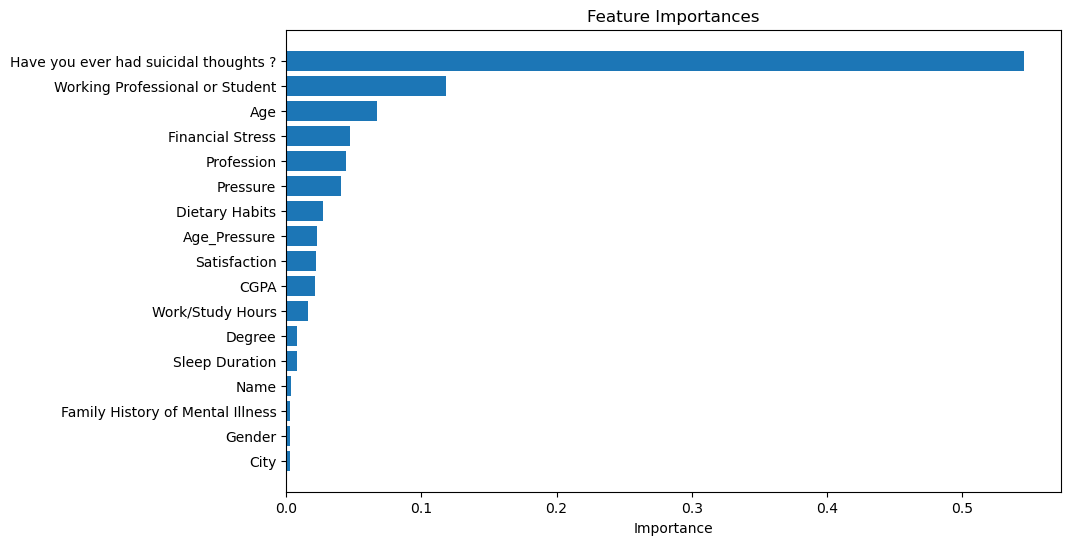

In [31]:
xgb_clf.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_clf.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

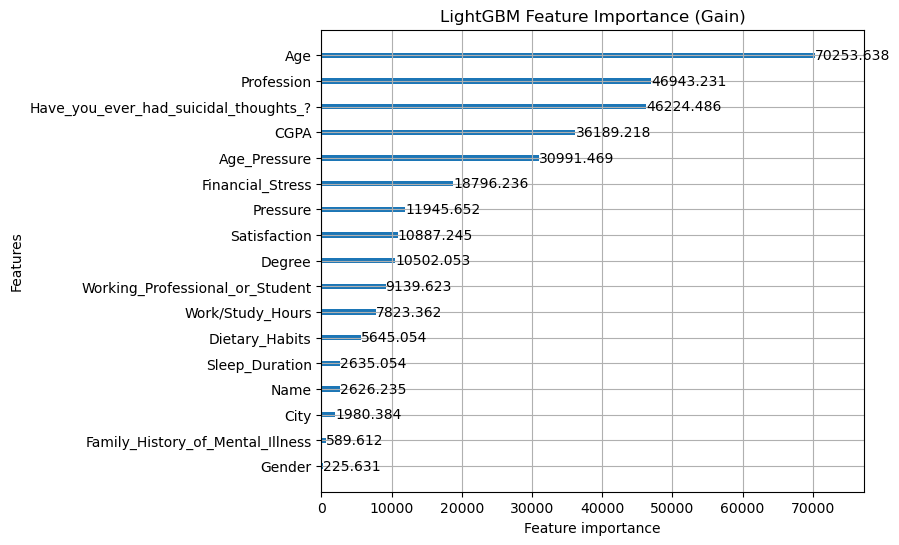

In [32]:
lgb_clf.fit(X_train, y_train)
lgb.plot_importance(lgb_clf, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()